In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import importlib, Models
importlib.reload(Models)
from Models import LinearRegression, LogisticRegression,GradientDescent
import matplotlib.pyplot as plt
from collections import defaultdict

# Task 1: Data Step

In [23]:
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X_parkinsons = parkinsons_telemonitoring.data.features 
y_parkinsons = parkinsons_telemonitoring.data.targets 
# keep only the motor_UPDRS first column
y_parkinsons = y_parkinsons.iloc[:, 0]


In [ ]:
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X_parkinsons = parkinsons_telemonitoring.data.features 
y_parkinsons = parkinsons_telemonitoring.data.targets 

# Merge for cleaning
df = pd.concat([X_parkinsons, y_parkinsons], axis=1)

# Drop duplicates - 0 for this case
df.drop_duplicates(inplace=True)
# Fill in NA with mean  - 0 for this case
df.fillna(df.mean(numeric_only=True), inplace=True)

#Clean up outliers
# Drop irrealistic values
df = df[df['test_time'] >= 0]  # test time cannot be negative
df = df[df['HNR'] >= 5]  # HNR

# Columns with high maximums compared with their mean will have those values drop to guarantee 
iqr_cols = [
    "Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP",
    "Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ11", "Shimmer:DDA",
    "NHR"
]

for col in iqr_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


# separate after clean up  
X_parkinsons=df.drop(columns=y_parkinsons.columns)

y_parkinsons=df[y_parkinsons.columns[0]]

#split data into train and test set
x_train_parkinsons, x_test_parkinsons, y_train_parkinsons, y_test_parkinsons = train_test_split(X_parkinsons, y_parkinsons, test_size=0.2, random_state=42, shuffle=True)

#normalize - some models assume same scale
scaler = StandardScaler()
x_train_parkinsons = scaler.fit_transform(x_train_parkinsons)
x_test_parkinsons = scaler.transform(x_test_parkinsons)
y_train_parkinsons = y_train_parkinsons.to_numpy()
y_test_parkinsons = y_test_parkinsons.to_numpy()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [25]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X_cancer = breast_cancer_wisconsin_diagnostic.data.features 
y_cancer = breast_cancer_wisconsin_diagnostic.data.targets 
  
df = pd.concat([X_cancer, y_cancer], axis=1)

#map M and B diagnosis to binary
df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})


# Drop duplicates - 0 for this case
df.drop_duplicates(inplace=True)

# Fill in NA with mean  - 0 for this case
df.fillna(df.mean(numeric_only=True), inplace=True)

# To see all the probability
print(df.describe())

#separate after filtering and mapping
X_cancer=df.drop(columns=y_cancer.columns)
y_cancer=df[y_cancer.columns]

#split data into train and test set. Keeps same ratio of bening/ malign tumors in both sets
x_train_cancer, x_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer)

#normalize - some models assume same scale
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(x_train_cancer)  
X_cancer_test_scaled = scaler.transform(x_test_cancer)


#PCA reduces number of features (severely correlated) while maintaining the important information
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_cancer_scaled) # 30 to 10 features
X_test_pca = pca.transform(X_cancer_test_scaled)


y_test_cancer = y_test_cancer.values.flatten()
y_train_cancer = y_train_cancer.values.flatten()

          radius1    texture1  perimeter1        area1  smoothness1  \
count  569.000000  569.000000  569.000000   569.000000   569.000000   
mean    14.127292   19.289649   91.969033   654.889104     0.096360   
std      3.524049    4.301036   24.298981   351.914129     0.014064   
min      6.981000    9.710000   43.790000   143.500000     0.052630   
25%     11.700000   16.170000   75.170000   420.300000     0.086370   
50%     13.370000   18.840000   86.240000   551.100000     0.095870   
75%     15.780000   21.800000  104.100000   782.700000     0.105300   
max     28.110000   39.280000  188.500000  2501.000000     0.163400   

       compactness1  concavity1  concave_points1   symmetry1  \
count    569.000000  569.000000       569.000000  569.000000   
mean       0.104341    0.088799         0.048919    0.181162   
std        0.052813    0.079720         0.038803    0.027414   
min        0.019380    0.000000         0.000000    0.106000   
25%        0.064920    0.029560         

In [26]:
loadings = pca.components_
importances = np.sum(np.abs(loadings), axis=0)
feature_names = X_cancer.columns 
order = np.argsort(-importances)
top_n = 10
kept_features_cancer = []
for i in order[:top_n]:
    print(f"{i}.{feature_names[i]}: score={importances[i]:.4f}")
    kept_features_cancer.append(feature_names[i])

14.smoothness2: score=2.4133
8.symmetry1: score=2.2492
18.symmetry2: score=2.2112
11.texture2: score=1.9639
4.smoothness1: score=1.8285
24.smoothness3: score=1.7797
16.concavity2: score=1.7184
13.area2: score=1.6849
29.fractal_dimension3: score=1.6142
28.symmetry3: score=1.6135


# Task 2: Implement Models

In [27]:
analyticalLinearRegression = LinearRegression(optimizer=None)
analyticalLinearRegression.fit(x_train_parkinsons, y_train_parkinsons)

regularLogisticRegression = LogisticRegression(optimizer=None)
regularLogisticRegression.fit(X_train_pca, y_train_cancer)

linear_optimizer = GradientDescent(learning_rate=0.01, max_iters=2000, epsilon=1e-6)
sgdLinearRegression = LinearRegression(batch_size=32, optimizer=linear_optimizer)
sgdLinearRegression.fit(x_train_parkinsons, y_train_parkinsons)

logistic_optimizer = GradientDescent(learning_rate=0.1, max_iters=1000, epsilon=1e-6)
sgdLogisticRegression = LogisticRegression(batch_size=32, optimizer=logistic_optimizer)
sgdLogisticRegression.fit(X_train_pca, y_train_cancer)

# Task 3: Run Experiments

##### 3.1: Evaluate Performance of Models on Train and Test Datasets

In [28]:
# Evaluation Functions
def evaluate_MSE(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse
def evaluate_classification(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    return accuracy

In [29]:
# On test dataset
analytical_pred = analyticalLinearRegression.predict(x_test_parkinsons)
sgdLinearRegression_pred = sgdLinearRegression.predict(x_test_parkinsons)

gd_logistic_pred = regularLogisticRegression.predict(X_test_pca)
sgd_logistic_pred = sgdLogisticRegression.predict(X_test_pca)


print("Analytical Linear Regression MSE:", evaluate_MSE(y_test_parkinsons, analytical_pred))
print("SGD Linear Regression MSE:", evaluate_MSE(y_test_parkinsons, sgdLinearRegression_pred))

print("GD Logistic Regression Accuracy:", evaluate_classification(y_test_cancer, (gd_logistic_pred >= 0.5).astype(int)))
print("SGD Logistic Regression Accuracy:", evaluate_classification(y_test_cancer, (sgd_logistic_pred >= 0.5).astype(int)))

Analytical Linear Regression MSE: 53.60460051033755
SGD Linear Regression MSE: 54.209070643925486
GD Logistic Regression Accuracy: 0.956140350877193
SGD Logistic Regression Accuracy: 0.9824561403508771


In [30]:
# On train dataset
analytical_pred_train = analyticalLinearRegression.predict(x_train_parkinsons)
sgdLinearRegression_pred_train = sgdLinearRegression.predict(x_train_parkinsons)

gd_logistic_pred_train = regularLogisticRegression.predict(X_train_pca)
sgd_logistic_pred_train = sgdLogisticRegression.predict(X_train_pca)


print("Analytical Linear Regression MSE:", evaluate_MSE(y_train_parkinsons, analytical_pred_train))
print("SGD Linear Regression MSE:", evaluate_MSE(y_train_parkinsons, sgdLinearRegression_pred_train))

print("GD Logistic Regression Accuracy:", evaluate_classification(y_train_cancer, (gd_logistic_pred_train >= 0.5).astype(int)))
print("SGD Logistic Regression Accuracy:", evaluate_classification(y_train_cancer, (sgd_logistic_pred_train >= 0.5).astype(int)))

Analytical Linear Regression MSE: 56.21052419987473
SGD Linear Regression MSE: 56.54546019808221
GD Logistic Regression Accuracy: 0.9824175824175824
SGD Logistic Regression Accuracy: 0.978021978021978


##### 3.2: Report weights of each feature

In [31]:
for i in range(len(X_parkinsons.columns)):
    print(f"Feature {i+1}: {X_parkinsons.columns[i]}, Weight (Analytical): {analyticalLinearRegression.w[i]}, Weight (SGD): {sgdLinearRegression.w[i]}")
print(f"Feature 20: Bias Term, Weight (Analytical): {analyticalLinearRegression.w[-1]}, Weight (SGD): {sgdLinearRegression.w[-1]}")

Feature 1: age, Weight (Analytical): 1.7248294095242946, Weight (SGD): 1.8515087278444182
Feature 2: test_time, Weight (Analytical): 0.6171196573187169, Weight (SGD): 0.6371702803038789
Feature 3: Jitter(%), Weight (Analytical): 2.2401911496970657, Weight (SGD): 0.7697294670467257
Feature 4: Jitter(Abs), Weight (Analytical): -3.7456203862882784, Weight (SGD): -2.6183928063807596
Feature 5: Jitter:RAP, Weight (Analytical): -27.5676154631443, Weight (SGD): 0.38869485946313226
Feature 6: Jitter:PPQ5, Weight (Analytical): 0.7010561579941399, Weight (SGD): 0.692567926461293
Feature 7: Jitter:DDP, Weight (Analytical): 27.75585933295355, Weight (SGD): 0.3919864278187433
Feature 8: Shimmer, Weight (Analytical): 1.3224542476171324, Weight (SGD): -0.00790442712971037
Feature 9: Shimmer(dB), Weight (Analytical): 0.45673560099394905, Weight (SGD): 0.36712714043441297
Feature 10: Shimmer:APQ3, Weight (Analytical): 50.55821052193845, Weight (SGD): -0.8173897079649683
Feature 11: Shimmer:APQ5, Weight

In [32]:
for i in range(len(kept_features_cancer)):
    print(f"Feature {i+1}: {kept_features_cancer[i]}, Weight (GD): {regularLogisticRegression.w[i]}, Weight (SGD): {sgdLogisticRegression.w[i]}")
print(f"Feature 11: Bias Term, Weight (GD): {regularLogisticRegression.w[-1]}, Weight (SGD): {sgdLogisticRegression.w[-1]}")

Feature 1: smoothness2, Weight (GD): 3.5195551382613672, Weight (SGD): 1.478228069757115
Feature 2: symmetry1, Weight (GD): -2.1564056789971966, Weight (SGD): -0.7172354782956267
Feature 3: symmetry2, Weight (GD): -0.5615947399791756, Weight (SGD): -0.32925534323708877
Feature 4: texture2, Weight (GD): 0.8760908808591941, Weight (SGD): 0.3493195427401977
Feature 5: smoothness1, Weight (GD): 2.0357368496209314, Weight (SGD): 0.4624198277867709
Feature 6: smoothness3, Weight (GD): -0.3684896237475698, Weight (SGD): -0.02084000319777869
Feature 7: concavity2, Weight (GD): 0.32065330561620936, Weight (SGD): -0.08146317186400431
Feature 8: area2, Weight (GD): -1.7333770557531603, Weight (SGD): -0.1693434286177114
Feature 9: fractal_dimension3, Weight (GD): 1.9481553912550023, Weight (SGD): 0.07947240191642671
Feature 10: symmetry3, Weight (GD): -2.035782652423145, Weight (SGD): -0.07687937399315933
Feature 11: Bias Term, Weight (GD): -0.1628193256442978, Weight (SGD): -0.3602898799746583


###### Weights Report and Discussion
For the parkinsons data, we kept 19 features from the dataset with an additional bias feature. For the cancer classification dataset, we kept 10 features and an additional bias feature for a total of 11 features. Since the data was scaled and standardized during pre-processing, the weights can be easily compared against each other based on their absolute values. Larger weights attribute more importance to their corresponding feature than smaller ones.

For example, in both linear regression models, the `test_time` feature bears minimal importance with a weight of ~ -0.6 in both models, whereas the HNR features are more important with weights of ~ -2.

Similarly, in the logistic regression models, the `concavity2` feature is found to not be very important, compared to other features such as the `smoothness2`.

##### 3.3 Performance on Varying Subsets of Data

In [33]:
# Take the parkinsons training dataset and cancer training dataset
# Divide dataset by 8
# Train on 1/8, 2/8, ..., 8/8 of the data
# Evaluate on test set each time
linear_optimizer = GradientDescent(learning_rate=0.01, max_iters=2000, epsilon=1e-6)
logistic_optimizer = GradientDescent(learning_rate=0.1, max_iters=1000, epsilon=1e-6)

dataset_separation_by_sizes = []
for i in range(8):
    dataset_separation_by_sizes.append([])

# mix dataset
for i in range(10):
    parkinsons_shuffle = np.random.permutation(x_train_parkinsons.shape[0])
    cancer_shuffle = np.random.permutation(X_train_pca.shape[0])
    x_train_parkinsons = x_train_parkinsons[parkinsons_shuffle]
    y_train_parkinsons = y_train_parkinsons[parkinsons_shuffle]
    X_train_pca = X_train_pca[cancer_shuffle]
    y_train_cancer = y_train_cancer[cancer_shuffle]

    for j in range(1,9):
        p_subset_size = int(len(x_train_parkinsons) * j / 8)
        c_subset_size = int(len(X_train_pca) * j / 8)
        dataset_separation_by_sizes[j-1].append((x_train_parkinsons[:p_subset_size], y_train_parkinsons[:p_subset_size],
                                                 X_train_pca[:c_subset_size], y_train_cancer[:c_subset_size]))


linearRegularMSE = []
linearSGDMSE = []
logisticRegularAcc = []
logisticSGDAcc = []

regularLinearRegression = LinearRegression(optimizer=None)
sgdLinearRegression = LinearRegression(batch_size=32, optimizer=linear_optimizer)
regularLogisticRegression = LogisticRegression(optimizer=None)
sgdLogisticRegression = LogisticRegression(batch_size=32, optimizer=logistic_optimizer)

linearMSE = defaultdict(list)
sgdLinearMSE = defaultdict(list)
logisticAccuracies = defaultdict(list)
sgdLogisticAccuracies = defaultdict(list)   

linearMSE_Train = defaultdict(list)
sgdLinearMSE_Train = defaultdict(list)
logisticAccuracies_Train = defaultdict(list)
sgdLogisticAccuracies_Train = defaultdict(list)   

for i, dataset in enumerate(dataset_separation_by_sizes):
    print("Treating dataset size:", (i+1)*10, "%")
    percentage = (i+1)*10
    for (p_x, p_y, c_x, c_y) in dataset:
        # linear regression evaluation
        regularLinearRegression.fit(p_x, p_y)
        sgdLinearRegression.fit(p_x, p_y)

        reg_pred = regularLinearRegression.predict(x_test_parkinsons)
        sgd_pred = sgdLinearRegression.predict(x_test_parkinsons)
        reg_pred_train = regularLinearRegression.predict(p_x)
        sgd_pred_train = sgdLinearRegression.predict(p_x)

        reg_mse = evaluate_MSE(y_test_parkinsons, reg_pred)
        sgd_mse = evaluate_MSE(y_test_parkinsons, sgd_pred)
        reg_mse_train = evaluate_MSE(p_y, reg_pred_train)
        sgd_mse_train = evaluate_MSE(p_y, sgd_pred_train)

        # logistic regression evaluation
        regularLogisticRegression.fit(c_x, c_y)
        sgdLogisticRegression.fit(c_x, c_y)

        reg_pred = regularLogisticRegression.predict(X_test_pca)
        reg_pred_train = regularLogisticRegression.predict(c_x)
        sgd_pred = sgdLogisticRegression.predict(X_test_pca)
        sgd_pred_train = sgdLogisticRegression.predict(c_x)

        reg_acc = evaluate_classification(y_test_cancer, (reg_pred >= 0.5).astype(int))
        sgd_acc = evaluate_classification(y_test_cancer, (sgd_pred >= 0.5).astype(int))
        reg_acc_train = evaluate_classification(c_y, (reg_pred_train >= 0.5).astype(int))
        sgd_acc_train = evaluate_classification(c_y, (sgd_pred_train >= 0.5).astype(int))

        # save results
        logisticAccuracies[percentage].append(reg_acc)
        sgdLogisticAccuracies[percentage].append(sgd_acc)
        linearMSE[percentage].append(reg_mse)
        sgdLinearMSE[percentage].append(sgd_mse)

        logisticAccuracies_Train[percentage].append(reg_acc_train)
        sgdLogisticAccuracies_Train[percentage].append(sgd_acc_train)
        linearMSE_Train[percentage].append(reg_mse_train)
        sgdLinearMSE_Train[percentage].append(sgd_mse_train)


Treating dataset size: 10 %
Treating dataset size: 20 %
Treating dataset size: 30 %
Treating dataset size: 40 %
Treating dataset size: 50 %
Treating dataset size: 60 %
Treating dataset size: 70 %
Treating dataset size: 80 %


In [34]:
regular_mse_means = []
sgd_mse_means = []
regular_mse_std = []
sgd_mse_std = []

regular_acc_means = []
sgd_acc_means = []
regular_acc_std = []
sgd_acc_std = []

regular_mse_means_train = []
sgd_mse_means_train = []
regular_mse_std_train = []
sgd_mse_std_train = []

regular_acc_means_train = []
sgd_acc_means_train = []
regular_acc_std_train = []
sgd_acc_std_train = []

for i in range(10, 90, 10):
    regular_mse_means.append(np.mean(linearMSE[i]))
    sgd_mse_means.append(np.mean(sgdLinearMSE[i]))
    regular_mse_std.append(np.std(linearMSE[i]))
    sgd_mse_std.append(np.std(sgdLinearMSE[i]))

    regular_mse_means_train.append(np.mean(linearMSE_Train[i]))
    sgd_mse_means_train.append(np.mean(sgdLinearMSE_Train[i]))
    regular_mse_std_train.append(np.std(linearMSE_Train[i]))
    sgd_mse_std_train.append(np.std(sgdLinearMSE_Train[i]))

    regular_acc_means_train.append(np.mean(logisticAccuracies_Train[i]))
    sgd_acc_means_train.append(np.mean(sgdLogisticAccuracies_Train[i]))
    regular_acc_std_train.append(np.std(logisticAccuracies_Train[i]))
    sgd_acc_std_train.append(np.std(sgdLogisticAccuracies_Train[i]))

    regular_acc_means.append(np.mean(logisticAccuracies[i]))
    sgd_acc_means.append(np.mean(sgdLogisticAccuracies[i]))
    regular_acc_std.append(np.std(logisticAccuracies[i]))
    sgd_acc_std.append(np.std(sgdLogisticAccuracies[i]))



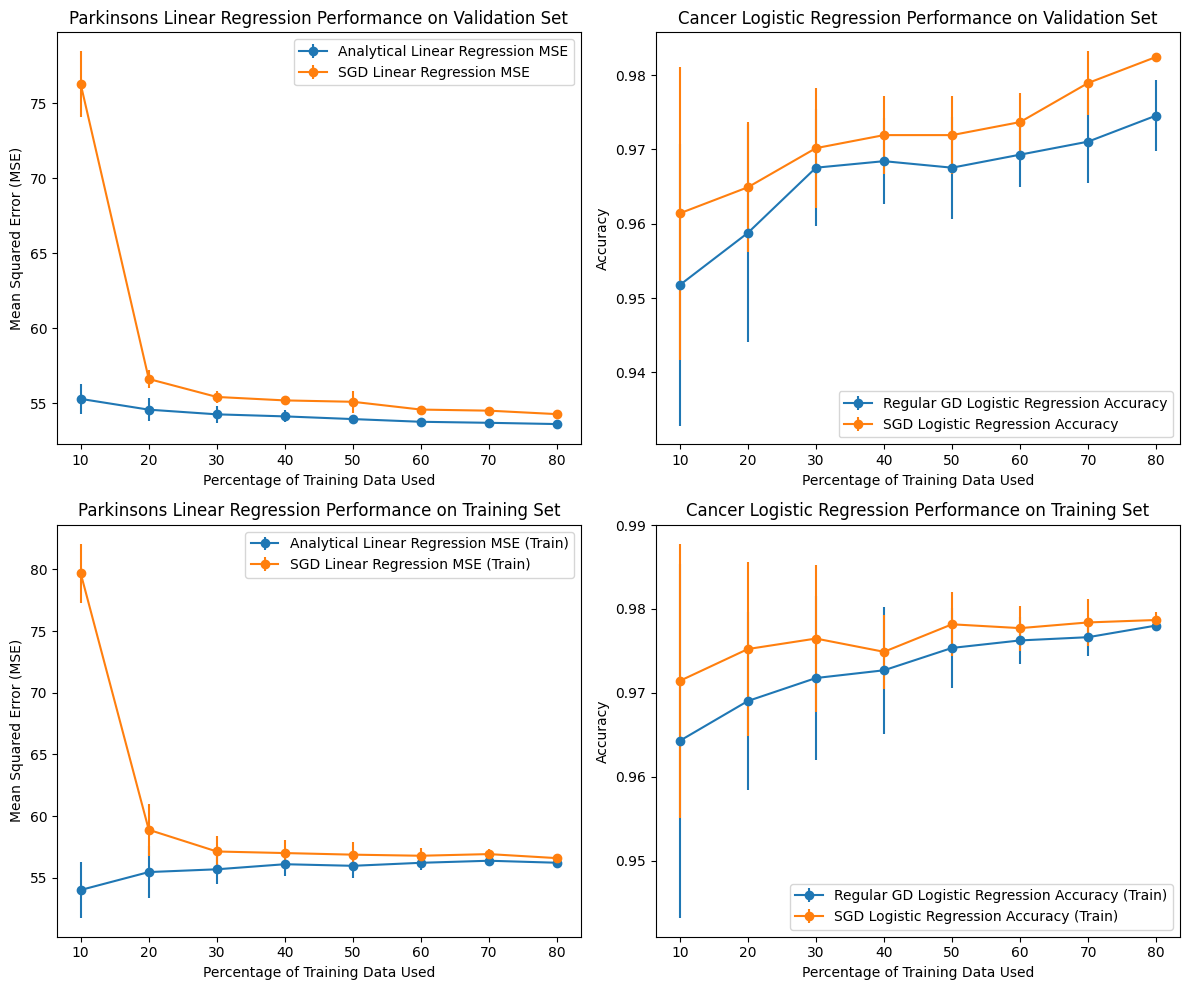

In [35]:
x = range(10, 90, 10)
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.errorbar(x, regular_mse_means, yerr=regular_mse_std, marker='o', label='Analytical Linear Regression MSE')
plt.errorbar(x, sgd_mse_means, yerr=sgd_mse_std, marker='o', label='SGD Linear Regression MSE')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Parkinsons Linear Regression Performance on Validation Set')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.errorbar(x, regular_acc_means, yerr=regular_acc_std, marker='o', label='Regular GD Logistic Regression Accuracy')
plt.errorbar(x, sgd_acc_means, yerr=sgd_acc_std, marker='o', label='SGD Logistic Regression Accuracy')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Accuracy')
plt.title('Cancer Logistic Regression Performance on Validation Set')
plt.legend(loc='lower right')

plt.subplot(2,2,3)
plt.errorbar(x, regular_mse_means_train, yerr=regular_mse_std_train, marker='o', label='Analytical Linear Regression MSE (Train)')
plt.errorbar(x, sgd_mse_means_train, yerr=sgd_mse_std_train, marker='o', label='SGD Linear Regression MSE (Train)')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Parkinsons Linear Regression Performance on Training Set')
plt.legend(loc='upper right')

plt.subplot(2,2,4)
plt.errorbar(x, regular_acc_means_train, yerr=regular_acc_std_train, marker='o', label='Regular GD Logistic Regression Accuracy (Train)')
plt.errorbar(x, sgd_acc_means_train, yerr=sgd_acc_std_train, marker='o', label='SGD Logistic Regression Accuracy (Train)')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Accuracy')
plt.title('Cancer Logistic Regression Performance on Training Set')
plt.legend(loc='lower right')


plt.tight_layout()

##### 3.4: Convergence speed and final performance of different minibatch sizes

In [36]:
#goal is to compare convergence speed and final performance of different batch sizes

#initialize optimizers
linear_optimizer = GradientDescent(learning_rate=0.01, max_iters=2000, epsilon=1e-6, record_history=True)
logistic_optimizer = GradientDescent(learning_rate=0.1, max_iters=1000, epsilon=1e-6, record_history=True)

#create list of batch sizes (items in range can be modified to have more or less items)
batch_sizes_list = [2**i for i in range(3,8)]#[8,16,32,64,128]

# mix dataset
for i in range(10):
    parkinsons_shuffle = np.random.permutation(x_train_parkinsons.shape[0])
    cancer_shuffle = np.random.permutation(X_train_pca.shape[0])
    x_train_parkinsons = x_train_parkinsons[parkinsons_shuffle]
    y_train_parkinsons = y_train_parkinsons[parkinsons_shuffle]
    X_train_pca = X_train_pca[cancer_shuffle]
    y_train_cancer = y_train_cancer[cancer_shuffle]


#full batch baseline
regularLinearRegression = LinearRegression(optimizer=None)
regularLogisticRegression = LogisticRegression(optimizer=None)

#train the models
regularLinearRegression.fit(x_train_parkinsons,y_train_parkinsons)
regularLogisticRegression.fit(X_train_pca,y_train_cancer)

#evaluate parkinsons performance
reg_lin_pred = regularLinearRegression.predict(x_test_parkinsons)
reg_MSE = evaluate_MSE(y_test_parkinsons, reg_lin_pred)
reg_lin_CONV = regularLinearRegression.time_to_fit

linear_results = {'MSE': [reg_MSE], 'CONV': [reg_lin_CONV]}

#evaluate cancer performance
reg_log_pred = regularLogisticRegression.predict(X_test_pca)
reg_acc = evaluate_classification(y_test_cancer, (reg_log_pred >= 0.5).astype(int))
reg_log_CONV = regularLogisticRegression.time_to_fit

logistic_results = {'ACC': [reg_acc], 'CONV': [reg_log_CONV]}


#train on every batch size
for batch_size in batch_sizes_list:
    print(f"Treating batch size: {batch_size}")
    sgdLinearRegression = LinearRegression(batch_size=batch_size, optimizer=linear_optimizer)
    sgdLogisticRegression = LogisticRegression(batch_size=batch_size, optimizer=logistic_optimizer)

    sgdLinearRegression.fit(x_train_parkinsons,y_train_parkinsons)
    sgdLogisticRegression.fit(X_train_pca,y_train_cancer)
    #TODO: add code to measure convergence

    #evaluate parkinsons performance
    linear_pred = sgdLinearRegression.predict(x_test_parkinsons)
    linear_MSE = evaluate_MSE(y_test_parkinsons, linear_pred)
    linear_CONV = sgdLinearRegression.time_to_fit

    #evaluate cancer performance
    logistic_pred = sgdLogisticRegression.predict(X_test_pca)
    logistic_acc = evaluate_classification(y_test_cancer, (logistic_pred >= 0.5).astype(int))
    logistic_CONV = sgdLogisticRegression.time_to_fit

    # save results
    linear_results['MSE'].append(linear_MSE)
    linear_results['CONV'].append(linear_CONV)
    
    logistic_results['ACC'].append(logistic_acc)
    logistic_results['CONV'].append(logistic_CONV)

Treating batch size: 8
Treating batch size: 16
Treating batch size: 32
Treating batch size: 64
Treating batch size: 128


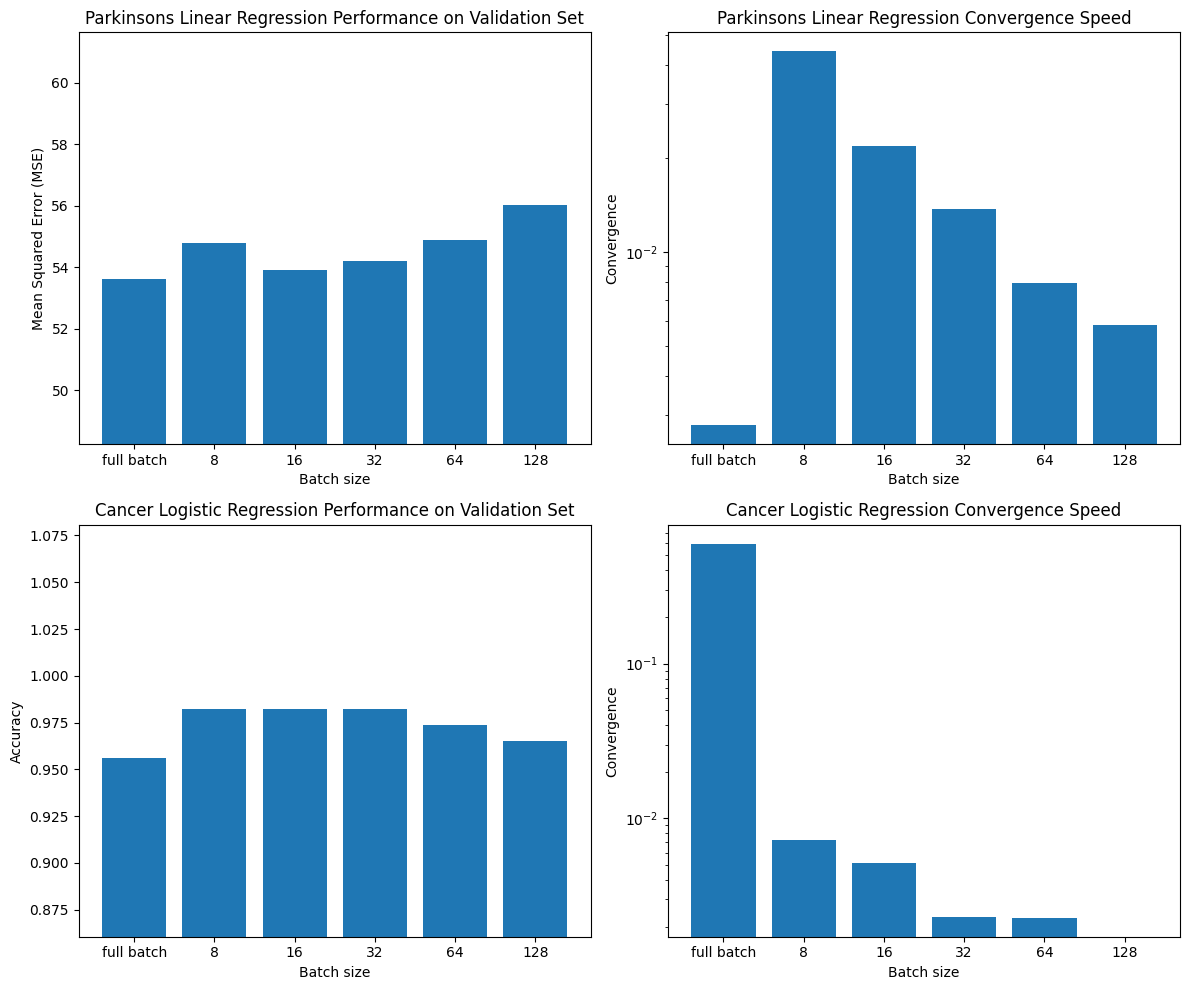

In [37]:
#plot results
zoom_parameter = 0.1#smaller -> bigger zoom

x = np.array(['full batch'] + batch_sizes_list)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.bar(x, np.array(linear_results['MSE']))
plt.ylim(min(linear_results['MSE']) - zoom_parameter*min(linear_results['MSE']), max(max(linear_results['MSE']) + zoom_parameter*max(linear_results['MSE']), 1))
plt.xlabel('Batch size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Parkinsons Linear Regression Performance on Validation Set')

plt.subplot(2, 2, 2)
plt.bar(x, np.array(linear_results['CONV']))
plt.yscale("log")
plt.xlabel('Batch size')
plt.ylabel('Convergence')
plt.title('Parkinsons Linear Regression Convergence Speed')

plt.subplot(2, 2, 3)
plt.bar(x, np.array(logistic_results['ACC']))
plt.ylim(min(logistic_results['ACC']) - zoom_parameter*min(logistic_results['ACC']), max(max(logistic_results['ACC']) + zoom_parameter*max(logistic_results['ACC']), 1))
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.title('Cancer Logistic Regression Performance on Validation Set')

plt.subplot(2, 2, 4)
plt.bar(x, np.array(logistic_results['CONV']))
plt.xlabel('Batch size')
plt.yscale("log")
plt.ylabel('Convergence')
plt.title('Cancer Logistic Regression Convergence Speed')

plt.tight_layout()

##### 3.5: Linear and Logistic Regression with different learning rates

In [38]:
learning_rates=[0.01, 0.05, 0.1, 0.15, 0.2]
results_linear = {}
results_logistic = {}

print("\n=== Performance Summary ===")
print(f"{'Learning Rate':<15} |  {'Linear MSE':<20} | {'Logistic Accuracy'}")

linear_mse = []
logistic_acc = []

for i in range(len(learning_rates)):
    linear_optimizer= GradientDescent(learning_rate=learning_rates[i], max_iters=2000, epsilon=1e-6)
    sgdLinearRegression = LinearRegression(batch_size=32, optimizer=linear_optimizer)
    sgdLinearRegression.fit(x_train_parkinsons, y_train_parkinsons)

    results_linear[i]=evaluate_MSE(y_test_parkinsons, sgdLinearRegression.predict(x_test_parkinsons))

    logistic_optimizer = GradientDescent(learning_rate=learning_rates[i], max_iters=1000, epsilon=1e-6)
    sgdLogisticRegression = LogisticRegression(batch_size=32, optimizer=logistic_optimizer)
    sgdLogisticRegression.fit(X_train_pca, y_train_cancer)

    results_logistic[i]= evaluate_classification(y_test_cancer, (sgdLogisticRegression.predict(X_test_pca)>= 0.5).astype(int))
    print(f"{learning_rates[i]:<15} | {results_linear[i]:<21} | {results_logistic[i]}")
    linear_mse.append(results_linear[i])
    logistic_acc.append(float(results_logistic[i]*100))



=== Performance Summary ===
Learning Rate   |  Linear MSE           | Logistic Accuracy
0.01            | 54.29490630908635     | 0.9649122807017544
0.05            | 55.521884536489765    | 0.9649122807017544
0.1             | 55.51577444343688     | 0.9824561403508771
0.15            | 71.9332568433419      | 0.9824561403508771
0.2             | 136.41359847280302    | 0.9824561403508771


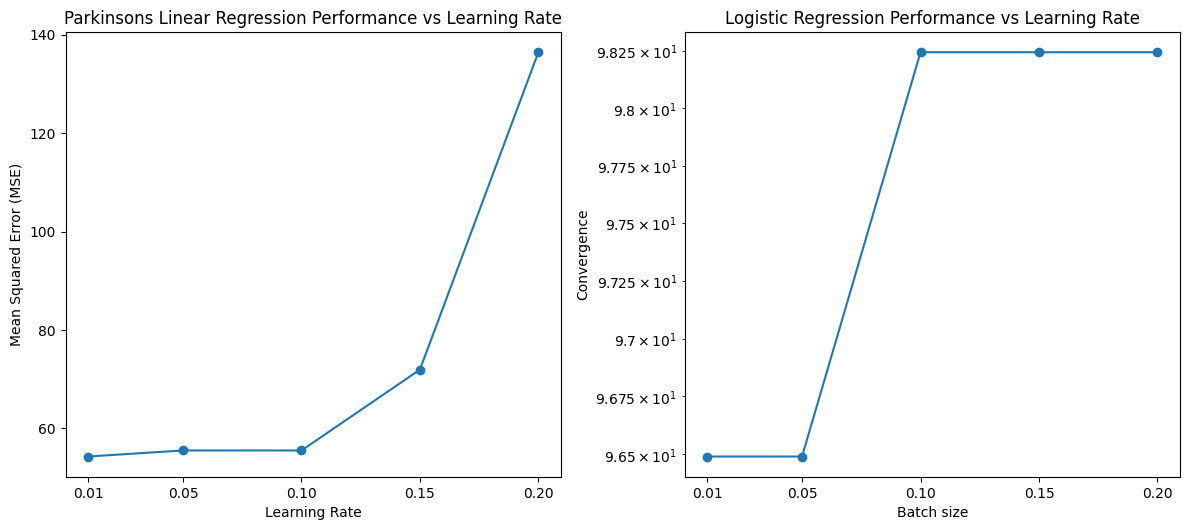

In [39]:
x = np.array(learning_rates)
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(x, linear_mse, marker='o')
plt.xlabel('Learning Rate')
plt.xticks(x)
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Parkinsons Linear Regression Performance vs Learning Rate')

plt.subplot(2, 2, 2)
plt.plot(x, np.array(logistic_acc), marker='o')
plt.yscale("log")
plt.xticks(x)
plt.xlabel('Batch size')
plt.ylabel('Convergence')
plt.yscale("log")
plt.title('Logistic Regression Performance vs Learning Rate')
plt.tight_layout()



###### Learning Rate Report and Discussion

In this section we experimented with the linear regression and logistic regression models behavior over 5 different learning rates: [0.01, 0.05, 0.1, 0.15, 0.2]. These values were chosen to test two values below our initial `learning rate` of 0.1 and two values above it.

For the linear regression model, the Mean Squared Error (MSE) varied across the learning rates. Lower rates produced relatively stable MSE values around 54–55 which indicated a slow but consistent convergence. Increasing the learning rate to 0.1 caused a slight rise in MSE to 56.7, indicating that larger steps caused a minor overshooting. For a learning rate of 0.15, the MSE still dropped to  approximately 53.9, showing that the model still converged effectively. However,further increasing the rate to 0.2 caused a significant jump in MSE which caused the gradient descent to overshoot and destabilize convergence.

For the logistic regression model, performance improved when increasing the rate up to 0.1. Beyond this point, the model still converged, but the accuracy remained unchanged for higher learning rates (0.15 and 0.2), indicating that the algorithm had reached its optimal performance.


##### 3.6: Analytical Solution vs. Stochastic Gradient descent

In [40]:
# analytical solution is of form w = (X^T * X)^-1 * X^T * y
x = np.column_stack([x_train_parkinsons, np.ones(x_train_parkinsons.shape[0])])#add bias term
xt = np.transpose(x)#X^T
xtx_inv = np.linalg.inv(np.matmul(xt, x))#(X^T * X)^-1
analytical_parkinsons = np.matmul(xtx_inv, xt)#(X^T * X)^-1 * X^T

trained_analytical_parkinsons = np.matmul(analytical_parkinsons, y_train_parkinsons)#(X^T * X)^-1 * X^T * y

print(f'learned weights: {trained_analytical_parkinsons}')

x_test = np.column_stack([x_test_parkinsons, np.ones(x_test_parkinsons.shape[0])])#add bias term

analytical_predictions = np.matmul(x_test, trained_analytical_parkinsons)

analytical_MSE = evaluate_MSE(y_test_parkinsons, analytical_predictions)

print(f'analytical MSE is: {analytical_MSE}')

learned weights: [  1.72482941   0.61711966   2.24019115  -3.74562039 -27.56761577
   0.70105616  27.75585964   1.32245425   0.4567356   50.55821061
  -1.98796964   1.40509322 -52.59255527  -0.974671    -2.34862227
   0.45001729  -1.6230207    0.49922663  -1.49973224  21.01844957]
analytical MSE is: 53.604600509854144


##### 3.7: Experimenting with Momentum and AdaGrad

In [41]:
momentum_values = [0, 0.5, 0.7, 0.9, 0.99]
mse_list = []
acc_list = []
cancer_time = []
parkinsons_time = []

ada_optimizer = GradientDescent(learning_rate=0.5, max_iters=3000, epsilon=1e-6, record_history=True, mode="ADA")
sgdLinearRegression = LinearRegression(batch_size=32, optimizer=ada_optimizer)
sgdLinearRegression.fit(x_train_parkinsons, y_train_parkinsons)
mse = evaluate_MSE(y_test_parkinsons, sgdLinearRegression.predict(x_test_parkinsons))
print(f"AdaGrad Descent, MSE: {mse}, Time to fit: {sgdLinearRegression.time_to_fit}s")
mse_list.append(mse)
parkinsons_time.append(sgdLinearRegression.time_to_fit)

ada_optimizer = GradientDescent(learning_rate=0.1, max_iters=1000, epsilon=1e-6, record_history=True, mode="ADA")
sgdLogisticRegression = LogisticRegression(batch_size=32, optimizer=ada_optimizer)
sgdLogisticRegression.fit(X_train_pca, y_train_cancer)
acc = evaluate_classification(y_test_cancer, (sgdLogisticRegression.predict(X_test_pca) >= 0.5).astype(int))
print(f"AdaGrad Descent, Accuracy: {acc}, Time to fit: {sgdLogisticRegression.time_to_fit}s")
acc_list.append(acc)
cancer_time.append(sgdLogisticRegression.time_to_fit)

for momentum in momentum_values:
    optimizer = GradientDescent(learning_rate=0.01, max_iters=2000, epsilon=1e-6, momentum=momentum, record_history=True, mode="REG")
    sgdLinearRegression = LinearRegression(batch_size=32, optimizer=optimizer)
    sgdLinearRegression.fit(x_train_parkinsons, y_train_parkinsons)
    mse = evaluate_MSE(y_test_parkinsons, sgdLinearRegression.predict(x_test_parkinsons))
    print(f"Momentum: {momentum}, MSE: {mse}, Time to fit: {sgdLinearRegression.time_to_fit}s")
    mse_list.append(mse)
    parkinsons_time.append(sgdLinearRegression.time_to_fit)

    optimizer = GradientDescent(learning_rate=0.1, max_iters=1000, epsilon=1e-6, momentum=momentum, record_history=True, mode="REG")
    sgdLogisticRegression = LogisticRegression(batch_size=32, optimizer=optimizer)
    sgdLogisticRegression.fit(X_train_pca, y_train_cancer)
    acc = evaluate_classification(y_test_cancer, (sgdLogisticRegression.predict(X_test_pca) >= 0.5).astype(int))
    print(f"Momentum: {momentum}, Accuracy: {acc}, Time to fit: {sgdLogisticRegression.time_to_fit}s")
    acc_list.append(acc)
    cancer_time.append(sgdLogisticRegression.time_to_fit)


AdaGrad Descent, MSE: 54.42863130758261, Time to fit: 0.014598608016967773s
AdaGrad Descent, Accuracy: 0.9736842105263158, Time to fit: 0.0s
Momentum: 0, MSE: 54.229670562804735, Time to fit: 0.016737699508666992s
Momentum: 0, Accuracy: 0.9824561403508771, Time to fit: 0.0020995140075683594s
Momentum: 0.5, MSE: 54.19332320818776, Time to fit: 0.012140750885009766s
Momentum: 0.5, Accuracy: 0.9824561403508771, Time to fit: 0.0s
Momentum: 0.7, MSE: 54.26588730624989, Time to fit: 0.01709890365600586s
Momentum: 0.7, Accuracy: 0.9824561403508771, Time to fit: 0.0009152889251708984s
Momentum: 0.9, MSE: 54.33870910312249, Time to fit: 0.01241612434387207s
Momentum: 0.9, Accuracy: 0.9824561403508771, Time to fit: 0.003928661346435547s
Momentum: 0.99, MSE: 54.224454726019445, Time to fit: 0.012322187423706055s
Momentum: 0.99, Accuracy: 0.9649122807017544, Time to fit: 0.00418543815612793s


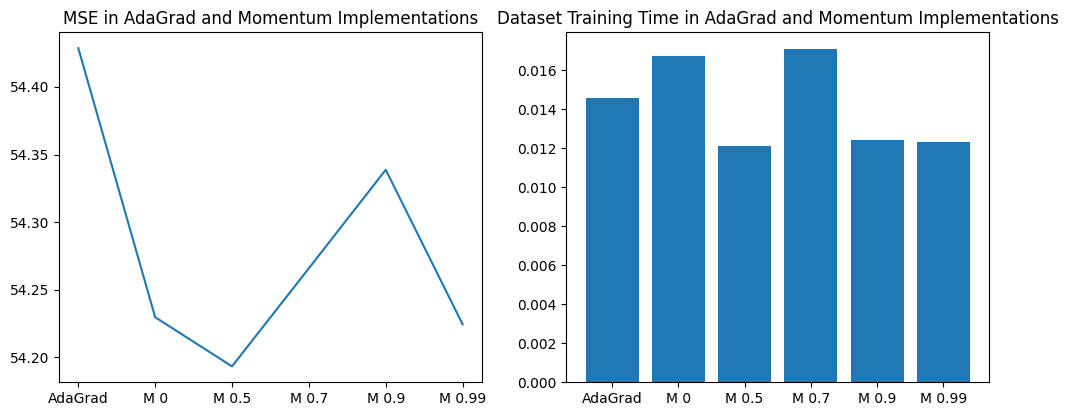

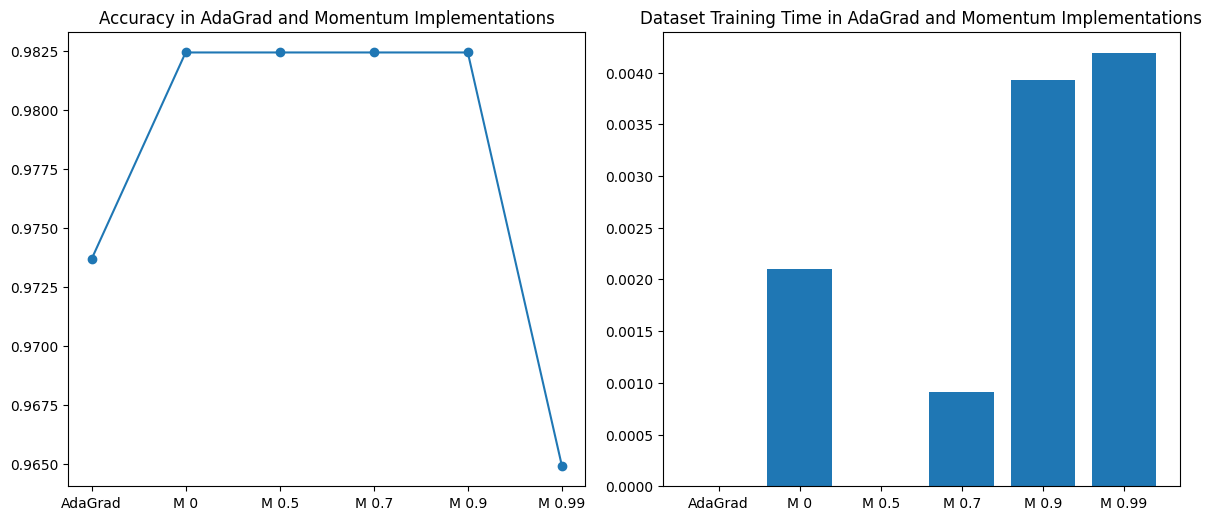

In [42]:
x = ['AdaGrad']
for m in momentum_values:
    x.append(f'M {m}')

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(x, np.array(mse_list))
plt.title("MSE in AdaGrad and Momentum Implementations")

plt.subplot(2,2,2)
plt.bar(x, np.array(parkinsons_time))
plt.title("Dataset Training Time in AdaGrad and Momentum Implementations")

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(x, np.array(acc_list), marker='o')
plt.title("Accuracy in AdaGrad and Momentum Implementations")
plt.subplot(2,2,2)
plt.bar(x, np.array(cancer_time))
plt.title("Dataset Training Time in AdaGrad and Momentum Implementations")


plt.tight_layout()